In [7]:
# imports and loading
import itertools as it
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import numpy as np
import os
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import sys
sys.path.insert(0, '../functions/')
import interface_GAMS as iG
import pickle
from adjustText import adjust_text
from sklearn.metrics import r2_score
import math

# settings
testing = True
small_dataset = True # only use the first 50 samples, mostly useful when using a limited license
pull_best_paras = False # pull best results from parameter_optimization, else use defaults


# load in settings flags
if testing:
    flags_filepath = '../options/test_gene_flags.csv'
    TF_flags_filepath = '../options/test_TF_flags.csv'
else:
    flags_filepath = '../options/gene_flags.csv'
    TF_flags_filepath = '../options/TF_flags.csv'
flags_df = pd.read_csv(flags_filepath, index_col = 0)
flags_df = pd.read_csv(flags_filepath, index_col = 0)
flags_df = flags_df[flags_df['include'] == True]

pickle_in = open('../data/interim/misc_dictionaries/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}

# one example motif vs promoter prediction

In [8]:
# settings
case = 'nan__Arginine'
mean_min_max = 'max' # the current model only allows one binding site for TF-gene, sometimes multiple binding sites exist, which score do you take?

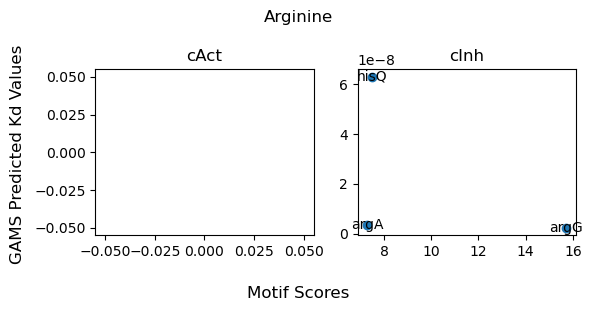

In [9]:
# plotting

# load in TF_flags dataframe
TF_flags_df = pd.read_csv(TF_flags_filepath, index_col = 0)
true_false = []
for iM in TF_flags_df.index:
    if iM in case:
        true_false.append(True)
    else:
        true_false.append(False)
TF_flags_df = TF_flags_df.loc[true_false]


# let's find our run_dir
GAMs_run_dir = '../GAMS/runs/'+case


if True:
    # first load in relevant info
    mRNA_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
    pickle_in = open('../data/interim/misc_dictionaries/gene_to_operon_to_motif_scores_dist_to_TSS.pkl', 'rb')
    gene_to_operon_to_motif_scores = pickle.load(pickle_in)
    pickle_in.close()
    pickle_in = open('../data/interim/misc_dictionaries/b_to_gene.pkl', 'rb')
    b_to_gene = pickle.load(pickle_in)
    pickle_in.close()
    gene_to_b = {v : k for k, v in b_to_gene.items()}
    gene_to_b.update({
        'yhbC' : 'b3170',
        #'sroD' : '', # not a real gene
    })
    # create operon to genes
    f = open('../data/external/regulonDB_files/OperonSet.txt', 'r')
    lines = f.readlines()
    f.close()
    operon_to_genes = {}
    for line in lines[38:]:
        operon = line.split('\t')[0]
        genes = line.split('\t')[5].split(',')
        operon_to_genes.update({operon : genes})
    operon_to_genes.update({
        'metY-yhbC-nusA-infB-rbfA-truB-rpsO-pnp' : ['metY', 'yhbC', 'nusA', 'infB', 'rbfA', 'truB', 'rpsO', 'pnp'],
        'metY' : ['metY'],
        'hisJQMP' : ['hisJ', 'hisQ', 'hisM', 'hisP'],
        'fabHDG' : ['fabH', 'fabD', 'fabG'],
        'glnB' : ['glnB'],
        'prs' : ['prs'],
    })

    # organize this by regulator to gene to motif scores
    cAct_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cAct_mapping.csv', index_col = 0)
    cInh_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cInh_mapping.csv', index_col = 0)
    reg_to_gene_to_scores = {}
    for index0, row in TF_flags_df.iterrows():
        GAMS_genes = cAct_mapping.index[cAct_mapping[index0] != 0].to_list() + cInh_mapping.index[cInh_mapping[index0] != 0].to_list()

        reg = row['TF']
        reg_to_gene_to_scores.update({reg : {}})
        if row['TF'][0].upper()+row['TF'][1:] not in gene_to_operon_to_motif_scores:
            continue
        for operon, motif_scores in gene_to_operon_to_motif_scores[row['TF'][0].upper()+row['TF'][1:]].items():
            if operon not in operon_to_genes:
                continue
            genes = operon_to_genes[operon]
            for gene in genes:
                if gene not in gene_to_b and gene not in ['sroD']:
                    print(gene)
                    continue
                if gene in ['sroD']:
                    continue
                b_gene = gene_to_b[gene]
                if b_gene not in reg_to_gene_to_scores[reg]:
                    reg_to_gene_to_scores[reg].update({b_gene : []})
                for score in motif_scores:
                    reg_to_gene_to_scores[reg][b_gene].append(score)
        # let's look at cAct kd's
        bby_cAct_kd_df = cAct_kd_df.loc[cAct_mapping.index[cAct_mapping[index0] != 0].to_list()]
        bby_cAct_kd_df = bby_cAct_kd_df[bby_cAct_kd_df['iM'] == index0][['Val']]
        scores = []
        keep = []
        labels1 = []
        for index in bby_cAct_kd_df.index:
            try:
                if mean_min_max == 'mean':
                    to_add = np.mean([val[0] for val in reg_to_gene_to_scores[reg][index]])
                elif mean_min_max == 'min':
                    to_add = np.min([val[0] for val in reg_to_gene_to_scores[reg][index]])
                elif mean_min_max == 'max':
                    to_add = np.max([val[0] for val in reg_to_gene_to_scores[reg][index]])
                scores.append(to_add)
                keep.append(index)
                labels1.append(b_to_gene[index])
            except:
                pass
        bby_cAct_kd_df = bby_cAct_kd_df.loc[keep]
        bby_cAct_kd_df['motif_scores'] = scores

        # let's look at cInh kd's
        bby_cInh_kd_df = cInh_kd_df.loc[cInh_mapping.index[cInh_mapping[index0] != 0].to_list()]
        bby_cInh_kd_df = bby_cInh_kd_df[bby_cInh_kd_df['iM'] == index0][['Val']]
        scores = []
        keep = []
        labels2 = []
        for index in bby_cInh_kd_df.index:
            if index in ['b1131']:
                continue
            try:
                if mean_min_max == 'mean':
                    to_add = np.mean([val[0] for val in reg_to_gene_to_scores[reg][index]])
                elif mean_min_max == 'min':
                    to_add = np.min([val[0] for val in reg_to_gene_to_scores[reg][index]])
                elif mean_min_max == 'max':
                    to_add = np.max([val[0] for val in reg_to_gene_to_scores[reg][index]])
                scores.append(to_add)
                keep.append(index)
                labels2.append(b_to_gene[index])
            except:
                pass
        bby_cInh_kd_df = bby_cInh_kd_df.loc[keep]
        bby_cInh_kd_df['motif_scores'] = scores

        # plotting
        fig, axs = plt.subplots(1, 2, figsize = (6, 3))
        x = bby_cAct_kd_df['motif_scores']
        y = bby_cAct_kd_df['Val']
        axs[0].scatter(x, y)
        texts1 = [axs[0].text(x[i], y[i], labels1[i], ha='center', va='center') for i in range(len(x))]
        #adjust_text(texts1, arrowprops=dict(arrowstyle='-', color='k'))
        x = bby_cInh_kd_df['motif_scores']
        y = bby_cInh_kd_df['Val']
        axs[1].scatter(x, y)
        texts2 = [axs[1].text(x[i], y[i], labels2[i], ha='center', va='center') for i in range(len(x))]
        #adjust_text(texts2, arrowprops=dict(arrowstyle='-', color='k'))
        axs[0].set_title('cAct')
        axs[1].set_title('cInh')
        fig.supxlabel('Motif Scores')
        fig.supylabel('GAMS Predicted Kd Values')
        fig.suptitle(index0)
        plt.tight_layout()
        plt.savefig('../figures/GAMS_kd_vs_motif_'+index0+'.pdf', transparent = True)
        plt.show()

# model-wide motif vs promoter prediction

In [12]:
# settings
mean_min_max = 'max' # the current model only allows one binding site for TF-gene, sometimes multiple binding sites exist, which score do you take?
filter_dist = (-60, 60) # dist to TSS from reported, only consider options in this range

In [24]:
# first, create the dataframes

# load in necessary files
base_TF_flags_df = pd.read_csv(TF_flags_filepath, index_col = 0)
pickle_in = open('../data/interim/misc_dictionaries/gene_to_operon_to_motif_scores_dist_to_TSS.pkl', 'rb')
gene_to_operon_to_motif_scores = pickle.load(pickle_in)
pickle_in.close()
pickle_in = open('../data/interim/misc_dictionaries/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}
gene_to_b.update({
    'yhbC' : 'b3170',
    #'sroD' : '', # not a real gene
})
# create operon to genes
f = open('../data/external/regulonDB_files/OperonSet.txt', 'r')
lines = f.readlines()
f.close()
operon_to_genes = {}
for line in lines[38:]:
    operon = line.split('\t')[0]
    genes = line.split('\t')[5].split(',')
    operon_to_genes.update({operon : genes})
operon_to_genes.update({
    'metY-yhbC-nusA-infB-rbfA-truB-rpsO-pnp' : ['metY', 'yhbC', 'nusA', 'infB', 'rbfA', 'truB', 'rpsO', 'pnp'],
    'metY' : ['metY'],
    'hisJQMP' : ['hisJ', 'hisQ', 'hisM', 'hisP'],
    'fabHDG' : ['fabH', 'fabD', 'fabG'],
    'glnB' : ['glnB'],
    'prs' : ['prs'],
})

act_cases = []
act_genes = []
act_TF_kds = []
act_motif_scores = []
act_dist_to_TSS = []
inh_cases = []
inh_genes = []
inh_TF_kds = []
inh_motif_scores = []
inh_dist_to_TSS = []
for iMs_run in set([(str(row['act_iM']), str(row['inh_iM'])) for _, row in flags_df.iterrows()]):
    clean = [x for x in iMs_run if str(x) != 'nan']
    case = '__'.join([str(iM) for iM in iMs_run]).replace(' ', '_').replace('/', '_')

    # parse down TF_flags
    true_false = []
    for iM in base_TF_flags_df.index:
        if iM in iMs_run:
            true_false.append(True)
        else:
            true_false.append(False)
    TF_flags_df = base_TF_flags_df.loc[true_false]

    # let's find our run_dir
    if not os.path.exists('../GAMS/runs/'+case):
        continue
    GAMs_run_dir = '../GAMS/runs/'+case
    print(case+' : processing...')
    
    # load in results and dictionaries
    try:
        mRNA_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
    except:
        print('\t issue loading in GAMS results, continuing')
        continue

    # organize this by regulator to gene to motif scores
    cAct_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cAct_mapping.csv', index_col = 0)
    cInh_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cInh_mapping.csv', index_col = 0)
    reg_to_gene_to_scores = {}
    for index0, row in TF_flags_df.iterrows():
        GAMS_genes = cAct_mapping.index[cAct_mapping[index0] != 0].to_list() + cInh_mapping.index[cInh_mapping[index0] != 0].to_list()

        reg = row['TF']
        reg_to_gene_to_scores.update({reg : {}})
        if row['TF'][0].upper()+row['TF'][1:] not in gene_to_operon_to_motif_scores:
            print('\t'+row['gene_name']+' not found in motif search, continue with others')
            continue
        for operon, motif_scores in gene_to_operon_to_motif_scores[row['TF'][0].upper()+row['TF'][1:]].items():
            if operon not in operon_to_genes:
                continue
            genes = operon_to_genes[operon]
            for gene in genes:
                if gene not in gene_to_b and gene not in ['sroD']:
                    print(gene)
                    continue
                if gene in ['sroD']:
                    continue
                b_gene = gene_to_b[gene]
                if b_gene not in reg_to_gene_to_scores[reg]:
                    reg_to_gene_to_scores[reg].update({b_gene : []})
                for score in motif_scores:
                    reg_to_gene_to_scores[reg][b_gene].append(score)

        # let's look at cAct kd's
        bby_cAct_kd_df = cAct_kd_df.loc[cAct_mapping.index[cAct_mapping[index0] != 0].to_list()]
        bby_cAct_kd_df = bby_cAct_kd_df[bby_cAct_kd_df['iM'] == index0][['Val']]
        scores = []
        dists = []
        keep = []
        labels1 = []
        for index in bby_cAct_kd_df.index:
            try:
                # filter based on dist to TSS
                filtered_vals = [val[0] for val in reg_to_gene_to_scores[reg][index] if val[1] < filter_dist[1] and val[1] > filter_dist[0]]
                if mean_min_max == 'mean':
                    to_add = np.max(filtered_vals)
                elif mean_min_max == 'min':
                    to_add = np.max(filtered_vals)
                elif mean_min_max == 'max':
                    to_add = np.max(filtered_vals)
                dist = [val[1] for val in reg_to_gene_to_scores[reg][index] if val[0] == to_add]
                dists.append(dist)
                scores.append(to_add)
                keep.append(index)
                labels1.append(b_to_gene[index])
            except:
                pass
        bby_cAct_kd_df = bby_cAct_kd_df.loc[keep]
        bby_cAct_kd_df['motif_scores'] = scores
        bby_cAct_kd_df['dist_to_TSS'] = dists

        # let's look at cInh kd's
        bby_cInh_kd_df = cInh_kd_df.loc[cInh_mapping.index[cInh_mapping[index0] != 0].to_list()]
        bby_cInh_kd_df = bby_cInh_kd_df[bby_cInh_kd_df['iM'] == index0][['Val']]
        scores = []
        dists = []
        keep = []
        labels2 = []
        for index in bby_cInh_kd_df.index:
            if index in ['b1131']:
                continue
            try:
                # filter based on dist to TSS
                filtered_vals = [val[0] for val in reg_to_gene_to_scores[reg][index] if val[1] < filter_dist[1] and val[1] > filter_dist[0]]
                if mean_min_max == 'mean':
                    to_add = np.max(filtered_vals)
                elif mean_min_max == 'min':
                    to_add = np.max(filtered_vals)
                elif mean_min_max == 'max':
                    to_add = np.max(filtered_vals)
                dist = [val[1] for val in reg_to_gene_to_scores[reg][index] if val[0] == to_add]
                dists.append(dist)
                scores.append(to_add)
                keep.append(index)
                labels2.append(b_to_gene[index])
            except:
                pass
        bby_cInh_kd_df = bby_cInh_kd_df.loc[keep]
        bby_cInh_kd_df['motif_scores'] = scores
        bby_cInh_kd_df['dist_to_TSS'] = dists
        
        # save off
        for index, row in bby_cAct_kd_df.iterrows():
            act_cases.append(case)
            act_genes.append(index)
            act_TF_kds.append(row['Val'])
            act_motif_scores.append(row['motif_scores'])
            act_dist_to_TSS.append(row['dist_to_TSS'])
        for index, row in bby_cInh_kd_df.iterrows():
            inh_cases.append(case)
            inh_genes.append(index)
            inh_TF_kds.append(row['Val'])
            inh_motif_scores.append(row['motif_scores'])
            inh_dist_to_TSS.append(row['dist_to_TSS'])

# merge to dataframe
merged_act = pd.DataFrame(index = act_genes)
merged_act['case'] = act_cases
merged_act['TF_kd'] = act_TF_kds
merged_act['motif_scores'] = act_motif_scores
merged_act['dist_to_TSS'] = act_dist_to_TSS
merged_inh = pd.DataFrame(index = inh_genes)
merged_inh['case'] = inh_cases
merged_inh['TF_kd'] = inh_TF_kds
merged_inh['motif_scores'] = inh_motif_scores
merged_inh['dist_to_TSS'] = inh_dist_to_TSS

Crp-2__DhaR : processing...
Fatty_Acid__nan : processing...
	 issue loading in GAMS results, continuing
nan__Arginine : processing...


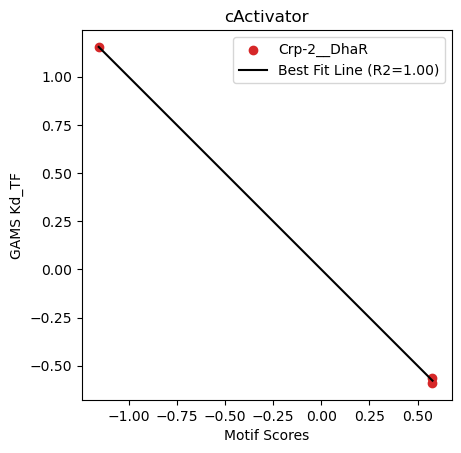

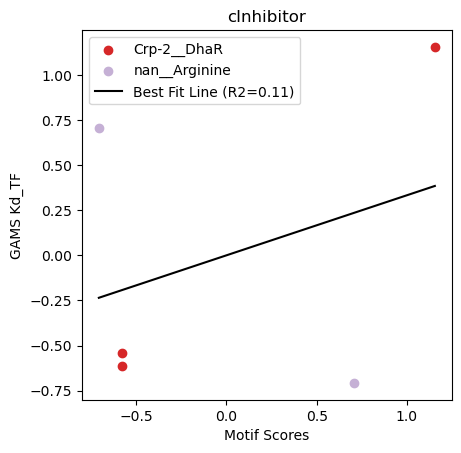

In [38]:
# plotting
colors = list(cm.tab20.colors)
markers = ['o', 'x']
limit_samples = []#'nan___Purine']
drop_cases = ['Fur-2___Fur-1', 'Cysteine-2___Cysteine-1']
case_to_color = {'BasR__nan': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'Biotin__nan': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'Capsule__nan': (1.0, 0.4980392156862745, 0.054901960784313725),
 'CpxR__nan': (1.0, 0.7333333333333333, 0.47058823529411764),
 'Cra__nan': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'Crp-1__nan': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'Crp-2__DhaR': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'Cysteine-2__Cysteine-1': (1.0, 0.596078431372549, 0.5882352941176471),
 'DNA_Damage__nan': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353),
 'EvgA__nan': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 'Fatty_Acid__nan': (0.5490196078431373,
  0.33725490196078434,
  0.29411764705882354),
 'FlhDC-2__FlhDC-1': (0.7686274509803922,
  0.611764705882353,
  0.5803921568627451),
 'Fnr-1__nan': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'Fur-2__Fur-1': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 'Fur-2__nan': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 'Lrp__nan': (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 'Lysine_T2SS__nan': (0.7372549019607844,
  0.7411764705882353,
  0.13333333333333333),
 'Magnesium__nan': (0.8588235294117647,
  0.8588235294117647,
  0.5529411764705883),
 'Maltose__nan': (0.09019607843137255,
  0.7450980392156863,
  0.8117647058823529),
 'Methionine__nan': (0.6196078431372549,
  0.8549019607843137,
  0.8980392156862745),
 'Nitrogen__nan': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765),
 'OxyR__nan': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'Phosphate-1__nan': (1.0, 0.4980392156862745, 0.054901960784313725),
 'Phosphate-2__nan': (1.0, 0.7333333333333333, 0.47058823529411764),
 'Pyruvate-1__nan': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313),
 'SoxS__nan': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'Sugar_Diacid__nan': (0.8392156862745098,
  0.15294117647058825,
  0.1568627450980392),
 'YcjW__nan': (1.0, 0.596078431372549, 0.5882352941176471),
 'nan__ArcA': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'nan__Arginine': (0.7725490196078432,
  0.6901960784313725,
  0.8352941176470589),
 'nan__Cysteine-1': (0.5490196078431373,
  0.33725490196078434,
  0.29411764705882354),
 'nan__Fur-1': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'nan__Lrp': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'nan__Nitrogen': (0.9686274509803922,
  0.7137254901960784,
  0.8235294117647058),
 'nan__Purine': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)}


mark_col = it.product(markers, colors)
plt.figure()
all_xs = []
all_ys = []
for case in set(merged_act.case):
    if (len(limit_samples) > 0 and case not in limit_samples) or case in drop_cases:
        continue
    bby = merged_act[merged_act['case'] == case]
    if len(bby) < 2:
        continue
    bby.loc[:, 'motif_scores'] = (bby['motif_scores'] - bby['motif_scores'].mean()) / bby['motif_scores'].std()
    bby.loc[:, 'TF_kd'] = (bby['TF_kd'] - bby['TF_kd'].mean()) / bby['TF_kd'].std()
    mark, col = next(mark_col)
    col = case_to_color[case]
    plt.scatter(bby['motif_scores'], bby['TF_kd'], color = col, marker = mark, label = case)
    for x, y in zip(bby['motif_scores'], bby['TF_kd']):
        if math.isnan(x) or math.isnan(y):
            continue
        all_xs.append(x)
        all_ys.append(y)

# best fit line
# Calculate the best-fit line
coefficients = np.polyfit(all_xs, all_ys, 1)
best_fit_line = np.poly1d(coefficients)
x_values = np.linspace(min(all_xs), max(all_xs), 100)
y_values = best_fit_line(x_values)
predicted_ys = best_fit_line(all_xs)
r2 = r2_score(all_ys, predicted_ys)
# Plot the best-fit line
plt.plot(x_values, y_values, color='k', label=f'Best Fit Line (R2={r2:.2f})')

# beautify
plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Motif Scores')
plt.ylabel('GAMS Kd_TF')
plt.title('cActivator')
plt.axis('square')
plt.savefig('../figures/overall_cAct.pdf', transparent = True)
plt.show()

mark_col = it.product(markers, colors)
plt.figure()
all_xs = []
all_ys = []
for case in set(merged_inh.case):
    if (len(limit_samples) > 0 and case not in limit_samples) or case in drop_cases:
        continue
    bby = merged_inh[merged_inh['case'] == case]
    if len(bby) < 2:
        continue
    bby.loc[:, 'motif_scores'] = (bby['motif_scores'] - bby['motif_scores'].mean()) / bby['motif_scores'].std()
    bby.loc[:, 'TF_kd'] = (bby['TF_kd'] - bby['TF_kd'].mean()) / bby['TF_kd'].std()
    mark, col = next(mark_col)
    col = case_to_color[case]
    plt.scatter(bby['motif_scores'], bby['TF_kd'], color = col, marker = mark, label = case)
    for x, y in zip(bby['motif_scores'], bby['TF_kd']):
        if math.isnan(x) or math.isnan(y):
            continue
        all_xs.append(x)
        all_ys.append(y)
        
# best fit line
# Calculate the best-fit line
coefficients = np.polyfit(all_xs, all_ys, 1)
best_fit_line = np.poly1d(coefficients)
x_values = np.linspace(min(all_xs), max(all_xs), 100)
y_values = best_fit_line(x_values)
predicted_ys = best_fit_line(all_xs)
r2 = r2_score(all_ys, predicted_ys)
# Plot the best-fit line
plt.plot(x_values, y_values, color='k', label=f'Best Fit Line (R2={r2:.2f})')


# beautify
plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Motif Scores')
plt.ylabel('GAMS Kd_TF')
plt.title('cInhibitor')
plt.axis('square')
plt.savefig('../figures/overall_cInh.pdf', transparent = True)
plt.show()

# plot correlations between sequence-based motif scores and GAMS-based Kd_TF values

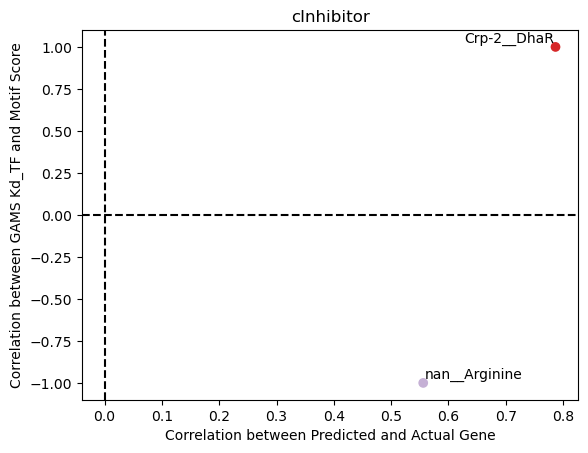

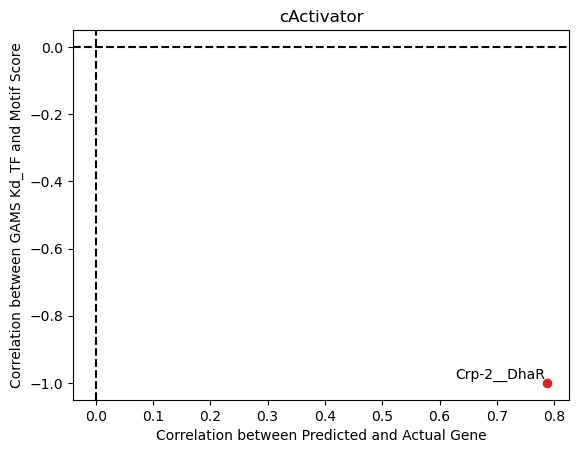

In [41]:
# plot gene-gene and motif-motif correlations

case_to_color = {'BasR__nan': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'Biotin__nan': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'Capsule__nan': (1.0, 0.4980392156862745, 0.054901960784313725),
 'CpxR__nan': (1.0, 0.7333333333333333, 0.47058823529411764),
 'Cra__nan': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'Crp-1__nan': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'Crp-2__DhaR': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'Cysteine-2__Cysteine-1': (1.0, 0.596078431372549, 0.5882352941176471),
 'DNA_Damage__nan': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353),
 'EvgA__nan': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 'Fatty_Acid__nan': (0.5490196078431373,
  0.33725490196078434,
  0.29411764705882354),
 'FlhDC-2__FlhDC-1': (0.7686274509803922,
  0.611764705882353,
  0.5803921568627451),
 'Fnr-1__nan': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'Fur-2__Fur-1': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 'Fur-2__nan': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 'Lrp__nan': (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 'Lysine_T2SS__nan': (0.7372549019607844,
  0.7411764705882353,
  0.13333333333333333),
 'Magnesium__nan': (0.8588235294117647,
  0.8588235294117647,
  0.5529411764705883),
 'Maltose__nan': (0.09019607843137255,
  0.7450980392156863,
  0.8117647058823529),
 'Methionine__nan': (0.6196078431372549,
  0.8549019607843137,
  0.8980392156862745),
 'Nitrogen__nan': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765),
 'OxyR__nan': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'Phosphate-1__nan': (1.0, 0.4980392156862745, 0.054901960784313725),
 'Phosphate-2__nan': (1.0, 0.7333333333333333, 0.47058823529411764),
 'Pyruvate-1__nan': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313),
 'SoxS__nan': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'Sugar_Diacid__nan': (0.8392156862745098,
  0.15294117647058825,
  0.1568627450980392),
 'YcjW__nan': (1.0, 0.596078431372549, 0.5882352941176471),
 'nan__ArcA': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'nan__Arginine': (0.7725490196078432,
  0.6901960784313725,
  0.8352941176470589),
 'nan__Cysteine-1': (0.5490196078431373,
  0.33725490196078434,
  0.29411764705882354),
 'nan__Fur-1': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'nan__Lrp': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'nan__Nitrogen': (0.9686274509803922,
  0.7137254901960784,
  0.8235294117647058),
 'nan__Purine': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)}


# load in
sample_corr_df = pd.read_csv('../data/interim/samples_correlation_df.csv', index_col = 0)
gene_corr_df = pd.read_csv('../data/interim/genes_correlation_df.csv', index_col = 0)

# cInhibitor
gene_gene_corrs = []
motif_kd_corrs = []
labels = []
colors = []
for case in set(merged_inh.case):
    num_vals = len(set(merged_inh[merged_inh.case == case].motif_scores))
    if num_vals < 2:
        continue # correlatoin with these few samples means little
    motif_kd_corr = merged_inh[merged_inh.case == case][['TF_kd', 'motif_scores']].corr().values[0, 1]
    if str(motif_kd_corr) == 'nan':
        continue # case is too small typically to have correlation values
    vals = []
    for gene in merged_inh[merged_inh.case == case].index:
        vals.append(gene_corr_df.loc[gene][gene])
    motif_kd_corrs.append(motif_kd_corr)
    gene_gene_corrs.append(np.mean(vals))
    labels.append(case)
    colors.append(case_to_color[case])
plt.scatter(gene_gene_corrs, motif_kd_corrs, color = colors, label = labels)
plt.xlabel('Correlation between Predicted and Actual Gene')
plt.ylabel('Correlation between GAMS Kd_TF and Motif Score')
plt.title('cInhibitor')
plt.axvline(x = 0, ls = '--', c = 'k')
plt.axhline(y = 0, ls = '--', c = 'k')
texts = [plt.text(gene_gene_corrs[i], motif_kd_corrs[i], labels[i], ha='center', va='center') for i in range(len(motif_kd_corrs))]
adjust_text(texts)
plt.savefig('../figures/corr_vals_for_cInhibitor.pdf', transparent = True)
plt.show()

# cActivator
gene_gene_corrs = []
motif_kd_corrs = []
labels = []
colors = []
for case in set(merged_act.case):
    num_vals = len(set(merged_act[merged_act.case == case].motif_scores))
    if num_vals < 2:
        continue # correlatoin with these few samples means little
    motif_kd_corr = merged_act[merged_act.case == case][['TF_kd', 'motif_scores']].corr().values[0, 1]
    if str(motif_kd_corr) == 'nan':
        continue # case is too small typically to have correlation values
    vals = []
    for gene in merged_act[merged_act.case == case].index:
        vals.append(gene_corr_df.loc[gene][gene])
    motif_kd_corrs.append(motif_kd_corr)
    gene_gene_corrs.append(np.mean(vals))
    labels.append(case)
    colors.append(case_to_color[case])
plt.scatter(gene_gene_corrs, motif_kd_corrs, color = colors)
plt.xlabel('Correlation between Predicted and Actual Gene')
plt.ylabel('Correlation between GAMS Kd_TF and Motif Score')
plt.title('cActivator')
plt.axvline(x = 0, ls = '--', c = 'k')
plt.axhline(y = 0, ls = '--', c = 'k')
texts = [plt.text(gene_gene_corrs[i], motif_kd_corrs[i], labels[i], ha='center', va='center') for i in range(len(motif_kd_corrs))]
adjust_text(texts)
plt.savefig('../figures/corr_vals_for_cActivator.pdf', transparent = True)
plt.show()